In [19]:
# %pip uninstall boardlib
%pip install boardlib
# %pip install pandas
# %pip install pandasgui
# Download the kilter dataset by running this in the terminal:
# boardlib database kilter ./kilter.db


[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import sqlite3
import boardlib
import pandas as pd
from pandasgui import show
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np

from PIL import Image, ImageDraw

from process import map_vgrade, id_to_index, id_to_coordinate, frame_to_ids, frame_to_triplets, triplets_to_matrix, frame_to_sparse_matrix, is_frame_valid, filter_frame, filter_climbs, sort_frame, filtered_df_to_text_file
from visualize import analyze_starting_hold_heights, plot_vgrade_counts, plot_hold_counts, print_unique_climbs_count, count_unique_words, draw_colored_circles_on_image, frame_to_imagecoords, frame_to_image
from markov import Markov, predict_valid_sequence
import embeddings as emb
from embeddings import hold_directions2, hold_directions, hold_magnitudes
import torch
from torch.utils.data import Dataset

### Creating SQL Database Connection and Converting tables to dfs ###

In [21]:

con = sqlite3.connect('kilter.db')
cur = con.cursor()
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
table_names = [entry[0] for entry in table_list]
table_names.sort()
print(table_names)
con.close()

def table_to_df(table_name):
    con = sqlite3.connect('kilter.db')

    df =  pd.read_sql_query(f"SELECT * FROM {table_name}", con)
    
    con.close()

    return df

# get all tables as dfs
for table_name in table_names:
    globals()[table_name] = table_to_df(table_name)
# print("The available dataframes are: \n\t" + "\n\t".join(table_names))

['android_metadata', 'ascents', 'attempts', 'beta_links', 'bids', 'circuits', 'circuits_climbs', 'climb_cache_fields', 'climb_random_positions', 'climb_stats', 'climbs', 'difficulty_grades', 'holes', 'kits', 'layouts', 'leds', 'placement_roles', 'placements', 'product_sizes', 'product_sizes_layouts_sets', 'products', 'products_angles', 'sets', 'shared_syncs', 'tags', 'user_permissions', 'user_syncs', 'users', 'walls', 'walls_sets']


### Create Filtered DF with Merged Tables

In [22]:
# print(globals()['ascents'].head().to_string(index=False)) #for printing head of table

def merge_filter_climbs(climbs, climb_stats):
    merged_df = pd.merge(climbs, climb_stats, left_on='uuid', right_on='climb_uuid', how='inner')
    merged_df = merged_df[merged_df['layout_id'] == 1]
    
    # Remove rows with 2 or less ascensionists
    merged_df = merged_df[merged_df['ascensionist_count'] >= 1]  # about 101629 climbs

    merged_df['vgrade'] = merged_df['display_difficulty'].apply(map_vgrade)

    filtered_columns = ['name','vgrade','angle_y','display_difficulty','created_at', 'ascensionist_count','frames','fa_username', 'benchmark_difficulty',  'is_draft',  'climb_uuid']
    filtered_df = merged_df.loc[:, filtered_columns]
    
    filtered_df = filtered_df.drop_duplicates(subset=['name'])
    
    filtered_df['hold_count'] = filtered_df['frames'].str.count('p')

    filtered_df = filtered_df[filtered_df['hold_count'] <=21] # 21 is about 100649 climbs
    return filtered_df

climbs = globals()['climbs']
climb_stats=globals()['climb_stats']
filtered_df = merge_filter_climbs(climbs, climb_stats)

# print("Number of climbs:", filtered_df.shape[0])

### Some Graphs

In [23]:
# plot_vgrade_counts(filtered_df)
# plot_hold_counts(filtered_df)
# average_starting_hold_height, percentage_with_starting_holds_at_35 = analyze_starting_hold_heights(filtered_df)
# print_unique_climbs_count(filtered_df)


### Create Text File

In [24]:
filtered_df = filter_climbs(filtered_df, vgrade=-1, angle=-1)
filtered_df['frames'] = filtered_df['frames'].apply(sort_frame)
filtered_df_to_text_file(filtered_df, file_path='climbs.txt')



file_path = 'climbs.txt'

# def print_unique_words(file_path):
#     word_counts = count_unique_words(file_path)
#     if word_counts:
#         sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[0], reverse=True)
#         for word, count in sorted_word_counts:
#             print(word, count)


In [25]:
# frame = "p1476r15p1152r12p1172r12p1504r15p1200r13p1230r13p1252r13p1319r13p1335r13p1387r14p1165r15p1511r15p1216r13"
# frame_to_image(frame)

### Markov Chain Model

Successfully Trained
Valid Sequence: 1476r15 1128r12 1160r15 1204r13 1222r13 1251r13 1547r15 1269r13 1275r15 1284r13 1320r13 1337r13 1373r14
[(236, 847.0, 5), (213, 826, 2), (129, 742, 5), (549, 658, 3), (591, 616, 3), (381, 532, 3), (150, 503.0, 5), (423, 490, 3), (675, 490, 5), (339, 448, 3), (423, 364, 3), (423, 322, 3), (507, 238, 4)]


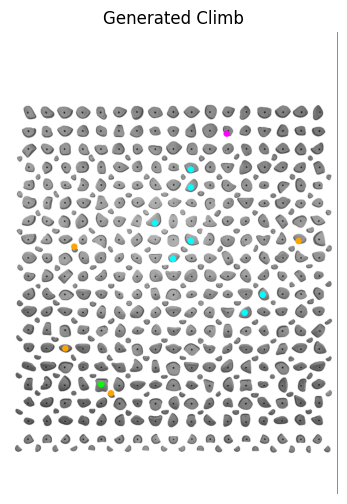

In [26]:
m = Markov(file_path='climbs.txt')
chain = m.model

valid_sequence = predict_valid_sequence(chain, '1476r15', number_of_words=13)
def frame_to_image(frame):
    image_path = "KilterBoardSetup.png"
    coords_list = frame_to_imagecoords(frame)
    print(coords_list)
    draw_colored_circles_on_image(image_path, coords_list)
print("Valid Sequence:", valid_sequence)
generated_frame = 'p' + valid_sequence.replace(' ', 'p')
frame_to_image(generated_frame)

# r12 - starthold  
# r13 - hand hold  
# r14 - finish hold 
# r15 - foot hold   


In [27]:
def ids_to_coordinates():
    # Iterate through the first range: 1073-1395
    for id in range(1073, 1396):
        coord = id_to_coordinate(id)
        # print(f"ID {id} converted to coordinates: {coord}")
    
    # Iterate through the second range: 1447-1599
    for id in range(1447, 1600):
        coord = id_to_coordinate(id)
        # print(f"ID {id} converted to coordinates: {coord}")

ids_to_coordinates()

### Prepare Data into npz file ###

In [28]:
def get_hold_vector(row, col):
    if not isinstance(row, int):
        raise TypeError(f"Row index must be an integer, got {type(row)} row: {row}")
    if not isinstance(col, int):
        raise TypeError(f"Column index must be an integer, got {type(col)} col: {col}")
    
    if row > 34 or col > 34:
        if row > col:
            raise ValueError(f"Row index {row} exceeds maximum allowed value of 34.")
        else:
            raise ValueError(f"Column index {col} exceeds maximum allowed value of 34.")
    
    if max(hold_directions[34 - row][col]) > 1:
        index = int(hold_directions[34 - row][col][0]) - 1
        hold_direction = hold_directions2[index].tolist()
    else:
        hold_direction = hold_directions[34 - row][col].tolist()
    
    hold_magnitude = hold_magnitudes[34 - row][col][0]
    
    return hold_direction, hold_magnitude

# hold_direction, hold_magnitude = get_hold_vector(row, col)

def unit_vector_to_sin(vector):
    x, y = vector
    angle_radians = np.arctan2(y, x)
    sin_value = np.sin(angle_radians)
    return sin_value

def unit_vector_to_cos(vector):
    x, y = vector
    angle_radians = np.arctan2(y, x)
    cos_value = np.cos(angle_radians)
    return cos_value

def modified_hold_quality(climb_angle, hold_quality):
    if isinstance(climb_angle, torch.Tensor):
        climb_angle_cpu = climb_angle.cpu().numpy()
    else:
        climb_angle_cpu = np.array(climb_angle)
    climb_angle_radians = np.deg2rad(climb_angle_cpu)
    modified_quality = np.cos(climb_angle_radians * hold_quality)
    return modified_quality

def interhold_angle(a, b):
    x1, y1 = a
    x2, y2 = b
    angle_radians = np.arctan2(y2 - y1, x2 - x1)
    return angle_radians

def average_unit_vectors(vectors):
    if len(vectors) == 1:
        return vectors[0]
    elif len(vectors) == 2:
        avg_x = (vectors[0][0] + vectors[1][0]) / 2
        avg_y = (vectors[0][1] + vectors[1][1]) / 2
        norm = np.sqrt(avg_x**2 + avg_y**2)
        return [avg_x / norm, avg_y / norm]
    else:
        raise ValueError("The input should be a list containing one or two unit vectors.")

def id_to_class_id(id):
    if id <=1089: # 0-16
        class_id = id - 1073 
    elif id <=1395: # 17-322
        class_id = id - 1090 + 17
    elif id <= 1464: # 323-340
        class_id = id - 1447 + 323
    elif id <= 1599: # 341-475
        class_id = id - 1465 + 341
    return class_id

def class_id_to_id(class_id):
    if class_id <= 16:  # 0-16
        id = class_id + 1073
    elif class_id <= 322:  # 17-322
        id = class_id + 1090 - 17
    elif class_id <= 340:  # 323-340
        id = class_id + 1447 - 323
    elif class_id <= 475:  # 341-475
        id = class_id + 1465 - 341 
    return id

def ids_to_hold_val_class_id(hold_class_id, val_class_id):
    hold_val_class_id = (hold_class_id) * 4 + val_class_id
    return hold_val_class_id

def hold_val_class_id_to_ids(hold_val_class_id):
    val_class_id = hold_val_class_id % 4
    hold_class_id = int((hold_val_class_id - val_class_id) /4)
    return hold_class_id, val_class_id

def climb_to_tupleslist(row):
    frames = row['frames']
    climb_angle = row['angle_y']
    climb_difficulty = map_vgrade(row['display_difficulty'])

    triplets = frame_to_triplets(frames)
    hold_ids =  frame_to_ids(frames)[0]
    feature_tuples = []

    for i, (x, y, val) in enumerate(triplets):
        hold_direction, hold_quality = get_hold_vector(y, x)
        hold_class_id = id_to_class_id(hold_ids[i])
        val_class_id = val-2
        hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

        # Check if hold_direction is a list of lists and average if necessary
        if isinstance(hold_direction[0], list):  
            hold_direction = average_unit_vectors(hold_direction)

        hold_angle = unit_vector_to_cos(hold_direction)
        modified_quality = modified_hold_quality(climb_angle, hold_quality)
        

        if i < len(triplets) - 1:
            next_x, next_y, _ = triplets[i + 1]
            inter_hold_angle = np.sin(interhold_angle((x, y), (next_x, next_y)))
        else:
            inter_hold_angle = 0  # Last hold doesn't have a next hold
        
        feature_tuple = (y, x, val- 2 , hold_class_id, hold_val_class_id, hold_angle, hold_quality)
        
        # Validate feature_tuple elements
        for j, feature in enumerate(feature_tuple):
            if not isinstance(feature, (int, float)):
                raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
        
        feature_tuples.append(feature_tuple)
    
    return feature_tuples

def df_to_npz(df, filename, num_climbs=None, random_climbs=False):
    climb_matrices = {}

    if num_climbs is not None and num_climbs != "all":
        if random_climbs:
            df = df.sample(n=num_climbs)
        else:
            df = df.head(num_climbs)

    for idx, row in df.iterrows():
        climb_name = row['name']
        feature_tuples = climb_to_tupleslist(row)

        matrix = np.array([list(t) for t in feature_tuples])
        climb_matrices[climb_name] = matrix

    np.savez_compressed(filename, **climb_matrices)

df_to_npz(filtered_df, 'climb_matrices.npz', num_climbs=40000, random_climbs=True)


def load_npz(file):
    data = np.load(file, allow_pickle=True)
    matrices = {key: data[key] for key in data}
    return matrices

def calculate_global_stats(matrices):
    all_data = np.concatenate([matrix for matrix in matrices.values()])
    global_means = np.mean(all_data, axis=0)
    global_stds = np.std(all_data, axis=0)

    # Avoid division by zero
    global_stds[global_stds == 0] = 1

    return global_means, global_stds


def standardize_matrix(matrix, global_means, global_stds):
    standardized_matrix = np.copy(matrix)
    standardized_matrix[:, [0, 1, 5, 6]] = (matrix[:, [0, 1, 5, 6]] - global_means[[0, 1, 5, 6]]) / global_stds[[0, 1, 5, 6]]
    return standardized_matrix


def standardize_npz(input_file, output_file):
    matrices = load_npz(input_file)
    global_means, global_stds = calculate_global_stats(matrices)
    print(global_means)
    
    standardized_matrices = {}
    for climb_name, matrix in matrices.items():
        standardized_matrix = standardize_matrix(matrix, global_means, global_stds)
        standardized_matrices[climb_name] = standardized_matrix
    
    np.savez_compressed(output_file, **standardized_matrices)
    return global_means, global_stds

# Example usage:
global_means, global_stds = standardize_npz('climb_matrices.npz', 'standardized_climb_matrices.npz')

def hold_to_tuple(hold_class_id, val,):
    # Convert the hold string to triplets (it will return a list with a single triplet)
    hold_id = class_id_to_id(int(hold_class_id))
    x, y = id_to_coordinate(hold_id)

    val_class_id = val-2
    hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

    # Get hold direction and hold quality
    hold_direction, hold_quality = get_hold_vector(y, x)
    
    # Check if hold_direction is a list of lists and average if necessary
    if isinstance(hold_direction[0], list):
        hold_direction = average_unit_vectors(hold_direction)

    hold_angle = unit_vector_to_cos(hold_direction)
    
    feature_tuple = (y, x, val_class_id, hold_class_id, hold_val_class_id, hold_angle, hold_quality)
    
    # Validate feature_tuple elements
    for j, feature in enumerate(feature_tuple):
        if not isinstance(feature, (int, float)):
            raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
    return feature_tuple

[ 1.72824453e+01  1.70439108e+01  1.63149766e+00  2.25039789e+02
  9.01790652e+02 -4.38285278e-03  5.92147695e-01]


### RNN Model ###

Train and Val Datasets Created
No sequences available for class_id 4
No sequences available for class_id 6
No sequences available for class_id 10
No sequences available for class_id 14
No sequences available for class_id 18
No sequences available for class_id 22
No sequences available for class_id 50
No sequences available for class_id 54
No sequences available for class_id 58
No sequences available for class_id 62
No sequences available for class_id 74
No sequences available for class_id 78
No sequences available for class_id 82
No sequences available for class_id 89
No sequences available for class_id 90
No sequences available for class_id 110
No sequences available for class_id 114
No sequences available for class_id 122
No sequences available for class_id 125
No sequences available for class_id 130
No sequences available for class_id 134
No sequences available for class_id 138
No sequences available for class_id 142
No sequences available for class_id 158
No sequences available for

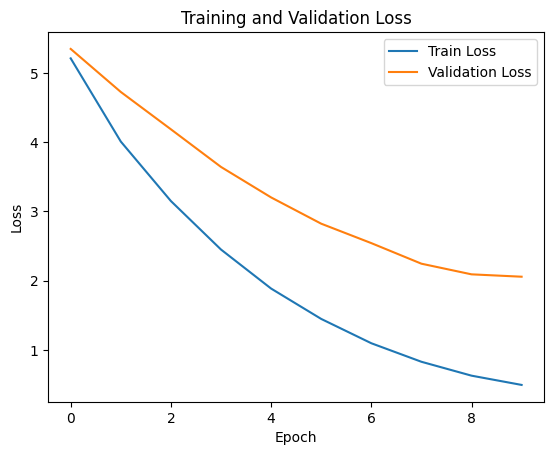

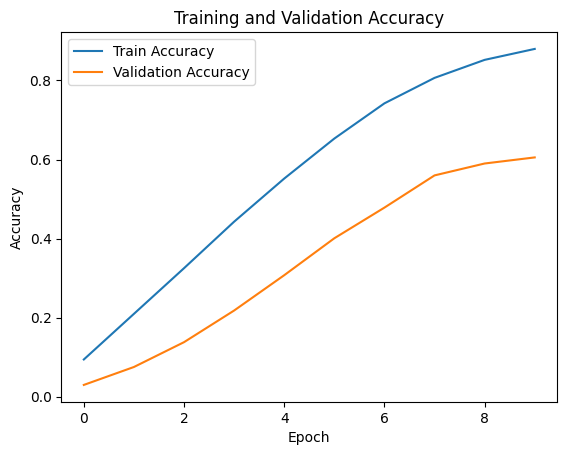

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.utils.parametrizations as weight_norm
import torch.nn.init as init
from collections import Counter
import random

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ClimbDataset(Dataset):
    def __init__(self, npz_file):
        self.data = np.load(npz_file, allow_pickle=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        climb_name = list(self.data.keys())[idx]
        climb_matrix = self.data[climb_name]
        return climb_matrix, climb_matrix[:, 4].astype(int)

class RNN(nn.Module):
    def __init__(self, input_size=7, hidden_size=128, num_layers=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Initialize LSTM weights
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                init.orthogonal_(param)
            elif 'bias' in name:
                init.constant_(param, 0)
        
        # Task-specific layer for hold_val_class prediction
        self.fc_hold_val_class = nn.Linear(hidden_size, 1904)  # Define the linear layer first
        
        # Initialize FC layer weights
        init.xavier_uniform_(self.fc_hold_val_class.weight)
        init.constant_(self.fc_hold_val_class.bias, 0)
        
        # Apply weight normalization using torch.nn.utils.parametrizations.weight_norm
        self.fc_hold_val_class = weight_norm.weight_norm(self.fc_hold_val_class, name='weight', dim=None)

    def forward(self, x, lengths, h0=None, c0=None):
        lengths = lengths.cpu().long()  # Ensure lengths tensor is on CPU and of type int64
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        if c0 is None:
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        packed_output, (hn, cn) = self.rnn(packed_input, (h0, c0))
        
        out, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # Get the output of the last time step
        out = out[torch.arange(out.size(0)), lengths - 1]
        
        hold_val_class_pred = self.fc_hold_val_class(out)
        
        return hold_val_class_pred, hn, cn

# Define collate function for DataLoader to handle variable-length sequences
def collate_fn(batch):
    sequences = [torch.tensor(climb_matrix, dtype=torch.float32) for climb_matrix, _ in batch]
    lengths = torch.tensor([len(climb_matrix) for climb_matrix, _ in batch])

    padded_sequences = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, padding_value=0)

    return padded_sequences, lengths

# Calculate class frequencies
def calculate_class_frequencies(dataset):
    class_counts = Counter()
    for i in range(len(dataset)):
        _, class_ids = dataset[i]
        class_counts.update(class_ids)
    return class_counts

# Create a balanced dataset by undersampling and oversampling
def create_balanced_dataset(dataset, target_class_freq=200):
    class_counts = calculate_class_frequencies(dataset)
    indices_by_class = {class_id: [] for class_id in class_counts}

    for idx in range(len(dataset)):
        _, class_ids = dataset[idx]
        for class_id in class_ids:
            indices_by_class[class_id].append(idx)

    balanced_indices = []

    for class_id, indices in indices_by_class.items():
        if len(indices) > target_class_freq:
            balanced_indices.extend(random.sample(indices, target_class_freq))
        else:
            balanced_indices.extend(indices)
            balanced_indices.extend(random.choices(indices, k=target_class_freq - len(indices)))

    return Subset(dataset, balanced_indices)

# Load your dataset
dataset = ClimbDataset('standardized_climb_matrices.npz')

# Calculate split sizes
total_size = len(dataset)
test_size = int(0.1 * total_size)  # 10% for test
remaining_size = total_size - test_size
train_size = int(0.7 * total_size)  # 70% of total for training (which is 70/90 of remaining)
val_size = remaining_size - train_size  # The remaining 20% of total for validation

# Split dataset into train, validation, and test sets
train_val_dataset, test_dataset = random_split(dataset, [remaining_size, test_size])
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])
print("Train and Val Datasets Created")

# Create balanced datasets for train and validation
train_dataset = create_balanced_dataset(train_dataset, target_class_freq=10)
val_dataset = create_balanced_dataset(val_dataset, target_class_freq=10)
print("Balanced Train and Val Datasets Created")

# Print sizes of the datasets
print(f"Train Dataset Size: {len(train_dataset)}")
print(f"Validation Dataset Size: {len(val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Create DataLoaders for balanced datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
print("Train and Val Loaders Created")

model = RNN().to(device)

# Define loss functions
criterion_hold_val_class = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 10

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0
    
    # Iterate over data
    for padded_sequences, lengths in train_loader:
        padded_sequences = padded_sequences.to(device)  # Move data to GPU if available
        lengths = lengths.to(device)

        optimizer.zero_grad()  # Reset gradients for the new batch

        # Forward pass
        hold_val_class_pred, h0, c0 = model(padded_sequences, lengths)
        
        # Compute hold_val_class loss
        next_tuple_hold_val_class = padded_sequences[torch.arange(padded_sequences.size(0)), lengths.cpu().long() - 1, 4].long()  # Extract target hold_val_class
        loss_hold_val_class = criterion_hold_val_class(hold_val_class_pred, next_tuple_hold_val_class)

        # Total loss
        batch_loss = loss_hold_val_class
        # Backward pass and optimize
        batch_loss.backward()
        optimizer.step()

        running_train_loss += batch_loss.item()
        
        # Calculate training accuracy
        correct_train_preds += (torch.argmax(hold_val_class_pred, dim=1) == next_tuple_hold_val_class).sum().item()
        total_train_preds += next_tuple_hold_val_class.size(0)
    
    # Compute average training loss and accuracy
    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_preds
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val_preds = 0
    total_val_preds = 0
    with torch.no_grad():
        for padded_sequences, lengths in val_loader:
            padded_sequences = padded_sequences.to(device)  # Move data to GPU if available
            lengths = lengths.to(device)

            # Forward pass
            hold_val_class_pred, h0, c0 = model(padded_sequences, lengths)

            # Compute hold_val_class loss
            next_tuple_hold_val_class = padded_sequences[torch.arange(padded_sequences.size(0)), lengths.cpu().long() - 1, 4].long()  # Extract target hold_val_class
            loss_hold_val_class = criterion_hold_val_class(hold_val_class_pred, next_tuple_hold_val_class)

            # Total loss
            batch_loss = loss_hold_val_class
            running_val_loss += batch_loss.item()

            # Calculate validation accuracy
            correct_val_preds += (torch.argmax(hold_val_class_pred, dim=1) == next_tuple_hold_val_class).sum().item()
            total_val_preds += next_tuple_hold_val_class.size(0)
    
    # Compute average validation loss and accuracy
    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val_preds / total_val_preds
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Plotting training and validation losses
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotting training and validation accuracies
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


Train and Val Datasets Created
Sequence Train and Val Datasets Created
Balanced Sequence Train and Val Datasets Created
Balanced Train Dataset Size: 333800
Balanced Validation Dataset Size: 290800
Test Dataset Size: 4000
Class frequencies in Balanced Train Dataset:
Class 1391: 200
Class 1455: 200
Class 300: 200
Class 452: 200
Class 637: 200
Class 909: 200
Class 1242: 200
Class 320: 200
Class 335: 200
Class 512: 200
Class 529: 200
Class 593: 200
Class 745: 200
Class 929: 200
Class 1069: 200
Class 1266: 200
Class 463: 200
Class 484: 200
Class 701: 200
Class 785: 200
Class 789: 200
Class 873: 200
Class 1274: 200
Class 232: 200
Class 497: 200
Class 513: 200
Class 709: 200
Class 761: 200
Class 1751: 200
Class 905: 200
Class 981: 200
Class 1125: 200
Class 1270: 200
Class 1427: 200
Class 324: 200
Class 384: 200
Class 1531: 200
Class 1599: 200
Class 585: 200
Class 1671: 200
Class 733: 200
Class 861: 200
Class 917: 200
Class 993: 200
Class 1053: 200
Class 1129: 200
Class 1258: 200
Class 251: 20

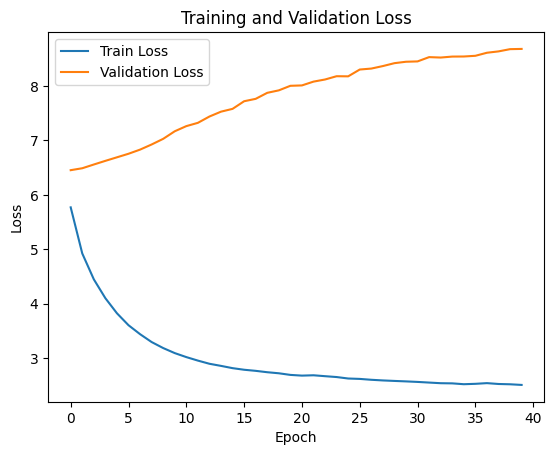

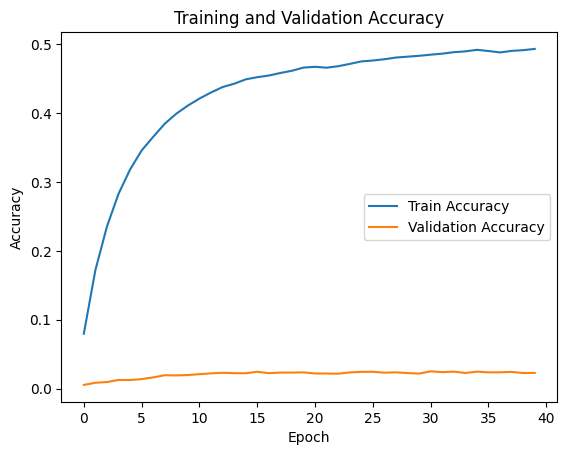

In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.utils.parametrizations as weight_norm
import torch.nn.init as init
from collections import Counter
import random

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ClimbDataset(Dataset):
    def __init__(self, npz_file):
        self.data = np.load(npz_file, allow_pickle=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        climb_name = list(self.data.keys())[idx]
        climb_matrix = self.data[climb_name]
        return climb_matrix, climb_matrix[:, 4].astype(int)

class SequenceDataset(Dataset):
    def __init__(self, dataset):
        self.sequences, self.labels = self.extract_sequences(dataset)

    def extract_sequences(self, dataset):
        sequences = []
        labels = []

        for i in range(len(dataset)):
            climb_matrix, class_ids = dataset[i]
            for j in range(1, len(climb_matrix)):
                sequence = climb_matrix[:j]  # Take the first j elements
                label = class_ids[j]         # Predict the j-th element
                sequences.append(sequence)
                labels.append(label)

        return sequences, labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)
        label = self.labels[idx]
        return sequence, label

class BalancedSequenceDataset(Dataset):
    def __init__(self, sequence_dataset, target_class_freq=200):
        self.sequence_dataset = sequence_dataset
        self.target_class_freq = target_class_freq
        self.balanced_indices = self.create_balanced_indices()

    def create_balanced_indices(self):
        class_to_indices = {}
        for idx in range(len(self.sequence_dataset)):
            _, label = self.sequence_dataset[idx]
            if label not in class_to_indices:
                class_to_indices[label] = []
            class_to_indices[label].append(idx)

        balanced_indices = []
        for label, indices in class_to_indices.items():
            if len(indices) > self.target_class_freq:
                balanced_indices.extend(random.sample(indices, self.target_class_freq))
            else:
                balanced_indices.extend(indices)
                balanced_indices.extend(random.choices(indices, k=self.target_class_freq - len(indices)))

        return balanced_indices

    def __len__(self):
        return len(self.balanced_indices)

    def __getitem__(self, idx):
        return self.sequence_dataset[self.balanced_indices[idx]]

class RNN(nn.Module):
    def __init__(self, input_size=7, hidden_size=128, num_layers=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Initialize LSTM weights
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                init.orthogonal_(param)
            elif 'bias' in name:
                init.constant_(param, 0)
        
        # Task-specific layer for hold_val_class prediction
        self.fc_hold_val_class = nn.Linear(hidden_size, 1904)  # Define the linear layer first
        
        # Initialize FC layer weights
        init.xavier_uniform_(self.fc_hold_val_class.weight)
        init.constant_(self.fc_hold_val_class.bias, 0)
        
        # Apply weight normalization using torch.nn.utils.parametrizations.weight_norm
        self.fc_hold_val_class = weight_norm.weight_norm(self.fc_hold_val_class, name='weight', dim=None)

    def forward(self, x, lengths, h0=None, c0=None):
        lengths = lengths.cpu().long()  # Ensure lengths tensor is on CPU and of type int64
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        if c0 is None:
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        packed_output, (hn, cn) = self.rnn(packed_input, (h0, c0))
        
        out, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # Get the output of the last time step
        out = out[torch.arange(out.size(0)), lengths - 1]
        
        hold_val_class_pred = self.fc_hold_val_class(out)
        
        return hold_val_class_pred, hn, cn

# Define collate function for DataLoader to handle variable-length sequences
def collate_fn(batch):
    sequences = [seq for seq, _ in batch]
    labels = torch.tensor([label for _, label in batch], dtype=torch.long)
    lengths = torch.tensor([len(seq) for seq in sequences])

    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)

    return padded_sequences, lengths, labels

# Load your dataset
dataset = ClimbDataset('standardized_climb_matrices.npz')

# Calculate split sizes
total_size = len(dataset)
test_size = int(0.1 * total_size)  # 10% for test
remaining_size = total_size - test_size
train_size = int(0.7 * total_size)  # 70% of total for training (which is 70/90 of remaining)
val_size = remaining_size - train_size  # The remaining 20% of total for validation

# Split dataset into train, validation, and test sets
train_val_dataset, test_dataset = random_split(dataset, [remaining_size, test_size])
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])
print("Train and Val Datasets Created")

# Create sequence datasets for train and validation
sequence_train_dataset = SequenceDataset(train_dataset)
sequence_val_dataset = SequenceDataset(val_dataset)
print("Sequence Train and Val Datasets Created")

# Create balanced sequence datasets for train and validation
balanced_sequence_train_dataset = BalancedSequenceDataset(sequence_train_dataset, target_class_freq=200)
balanced_sequence_val_dataset = BalancedSequenceDataset(sequence_val_dataset, target_class_freq=200)
print("Balanced Sequence Train and Val Datasets Created")

# Print sizes of the datasets
print(f"Balanced Train Dataset Size: {len(balanced_sequence_train_dataset)}")
print(f"Balanced Validation Dataset Size: {len(balanced_sequence_val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Function to calculate and print class frequencies
def print_class_frequencies(dataset, dataset_name):
    class_counts = Counter()
    for _, label in dataset:
        class_counts[label] += 1

    print(f"Class frequencies in {dataset_name}:")
    for label, count in class_counts.items():
        print(f"Class {label}: {count}")

print_class_frequencies(balanced_sequence_train_dataset, "Balanced Train Dataset")
print_class_frequencies(balanced_sequence_val_dataset, "Balanced Validation Dataset")

# Create DataLoaders for balanced sequence datasets
train_loader = DataLoader(balanced_sequence_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(balanced_sequence_val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
print("Train and Val Loaders Created")

model = RNN().to(device)

# Define loss functions
criterion_hold_val_class = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 40

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0
    
    # Iterate over data
    for padded_sequences, lengths, labels in train_loader:
        padded_sequences = padded_sequences.to(device)  # Move data to GPU if available
        lengths = lengths.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()  # Reset gradients for the new batch

        # Forward pass
        hold_val_class_pred, h0, c0 = model(padded_sequences, lengths)
        
        # Compute hold_val_class loss
        loss_hold_val_class = criterion_hold_val_class(hold_val_class_pred, labels)

        # Total loss
        batch_loss = loss_hold_val_class
        # Backward pass and optimize
        batch_loss.backward()
        optimizer.step()

        running_train_loss += batch_loss.item()
        
        # Calculate training accuracy
        correct_train_preds += (torch.argmax(hold_val_class_pred, dim=1) == labels).sum().item()
        total_train_preds += labels.size(0)
    
    # Compute average training loss and accuracy
    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = correct_train_preds / total_train_preds
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    correct_val_preds = 0
    total_val_preds = 0
    with torch.no_grad():
        for padded_sequences, lengths, labels in val_loader:
            padded_sequences = padded_sequences.to(device)  # Move data to GPU if available
            lengths = lengths.to(device)
            labels = labels.to(device)

            # Forward pass
            hold_val_class_pred, h0, c0 = model(padded_sequences, lengths)

            # Compute hold_val_class loss
            loss_hold_val_class = criterion_hold_val_class(hold_val_class_pred, labels)

            # Total loss
            batch_loss = loss_hold_val_class
            running_val_loss += batch_loss.item()

            # Calculate validation accuracy
            correct_val_preds += (torch.argmax(hold_val_class_pred, dim=1) == labels).sum().item()
            total_val_preds += labels.size(0)
    
    # Compute average validation loss and accuracy
    avg_val_loss = running_val_loss / len(val_loader)
    val_accuracy = correct_val_preds / total_val_preds
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)
    
    # Print epoch statistics
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

# Plotting training and validation losses
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotting training and validation accuracies
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


In [ ]:
total_instances = sum(len(batch[0]) for batch in DataLoader(train_dataset, batch_size=1, collate_fn=collate_fn))

In [ ]:
print(len(dataset))

40000


In [ ]:
import matplotlib.pyplot as plt

# Assuming weight_tensor is your tensor containing class weights
plt.figure(figsize=(10, 6))
plt.bar(range(len(weight_tensor)), weight_tensor.cpu().numpy())
plt.xlabel('Class Index')
plt.ylabel('Weight')
plt.title('Class Weights')
plt.show()

NameError: name 'weight_tensor' is not defined

<Figure size 1000x600 with 0 Axes>

### Generate RNN Climb ###

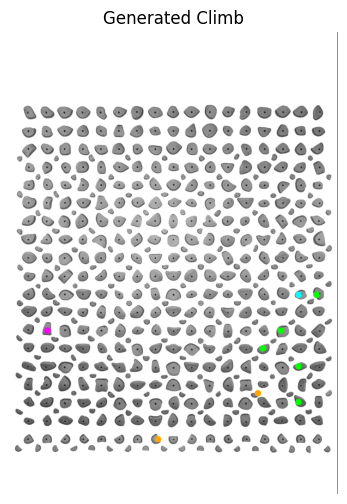

In [66]:
import torch.nn.functional as F 
def climb_to_tupleslist(row):
    frames = row['frames']

    triplets = frame_to_triplets(frames)
    hold_ids =  frame_to_ids(frames)[0]
    feature_tuples = []

    for i, (x, y, val) in enumerate(triplets):
        hold_direction, hold_quality = get_hold_vector(y, x)
        hold_class_id = id_to_class_id(hold_ids[i])
        val_class_id = val-2
        hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

        # Check if hold_direction is a list of lists and average if necessary
        if isinstance(hold_direction[0], list):  
            hold_direction = average_unit_vectors(hold_direction)

        hold_angle = unit_vector_to_cos(hold_direction)
        
        feature_tuple = (y, x, val- 2 , hold_class_id, hold_val_class_id, hold_angle, hold_quality)
        
        # Validate feature_tuple elements
        for j, feature in enumerate(feature_tuple):
            if not isinstance(feature, (int, float)):
                raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
        
        feature_tuples.append(feature_tuple)
    
    return feature_tuples



import random

def generate_climb(model, starting_hold_id, starting_val, num_holds):
    model.eval()
    
    # Initialize the starting tuple and convert to tensor
    starting_class_id = id_to_class_id(starting_hold_id)
    current_tuple = torch.tensor([hold_to_tuple(starting_class_id, starting_val)], dtype=torch.float).unsqueeze(0).to(device)

    generated_hold_ids = [starting_hold_id]
    generated_vals = [starting_val]

    # Initialize hidden states
    h0, c0 = None, None
    
    with torch.no_grad():
        for _ in range(num_holds - 1):
            lengths = torch.tensor([current_tuple.size(1)], dtype=torch.int64).to(device)

            hold_val_class_logits, h0, c0 = model(current_tuple, lengths, h0, c0)
            
            # Apply softmax to convert logits to probabilities
            hold_val_class_prob = F.softmax(hold_val_class_logits, dim=1)
            
            # hold_val_class_prob_cpu = hold_val_class_prob.squeeze().cpu().numpy()
            # plt.figure(figsize=(10, 6))
            # plt.bar(range(len(hold_val_class_prob_cpu)), hold_val_class_prob_cpu)
            # plt.xlabel('Hold Value Class ID')
            # plt.ylabel('Probability')
            # plt.title(f'Hold Value Class Probabilities at Step {_ + 1}')
            # plt.show()
            
            # hold_val_class_id = torch.argmax(hold_val_class_prob, dim=1).item()
            hold_val_top_indices = torch.topk(hold_val_class_prob, k=5, dim=1)[1].squeeze().tolist()
            hold_val_class_id = random.choice(hold_val_top_indices)
            hold_class_id, val_class = hold_val_class_id_to_ids(hold_val_class_id)
            generated_hold_ids.append(class_id_to_id(hold_class_id))
            generated_vals.append(val_class)

            # Prepare the next input
            next_tuple = hold_to_tuple(hold_class_id, val_class)
            next_tensor = torch.tensor([next_tuple], dtype=torch.float).unsqueeze(0).to(device)
            
            # Concatenate next_tensor along the sequence dimension (dim=1)
            current_tuple = torch.cat((current_tuple, next_tensor), dim=1)
    
    return generated_hold_ids, generated_vals

def climb_to_imagecoords(hold_ids, vals):
    
    triplets = []
    
    for id_1, id_2 in zip(hold_ids, vals):
        if 1090 <= id_1 <= 1395: # big holds
            index  = id_1 - 1090
            origin = [45, 910]
            interDistance = 42
            x = origin[0] + ((index % 17) * interDistance) 
            y = origin[1] - ((index // 17) * interDistance)
        
        elif 1073 <= id_1 <= 1089: # bottom large feet
            index  = id_1 - 1073
            origin = [724, 955]
            interDistance = 42
            x = origin[0] - (index * interDistance) 
            y = origin[1] 
        
        elif 1447 <= id_1 <= 1464: # bottom small feet
            index  = id_1 - 1447
            origin = [744, 976]
            interDistance = 42
            x = origin[0] - (index * interDistance) 
            y = origin[1] 

        elif 1465 <= id_1 <= 1599: # small holds
            index  = id_1 - 1465
            if ((index //9) % 2) == 0:# if row is even
                origin = [18, 891]
                interDistance = 86
                x = origin[0] + ((index % 9) * interDistance) 
                y = origin[1] - (((index // 9)/2) * interDistance)
            else: # if row is odd
                origin = [64, 847]
                interDistance = 86  #86
                x = origin[0] + (((index % 9)) * interDistance) 
                y = origin[1] - ((((index // 9)-1) /2) * interDistance)
        
        else:
            # If id_1 does not fall into any of the specified ranges, skip or handle accordingly
            continue
        
        # Create the triplet (x, y, color) and append to the triplets list
        triplet = (x, y, id_2)
        triplets.append(triplet)
    
    return triplets

def draw_colored_circles_on_image(image_path, circles, save_as='KilterBoardSetup1.png'):
    hold_colors = {0: '#00FF00', 1: '#00FFFF', 2: '#FF00FF', 3: 'orange'}
    # green, cyan, magenta, orange
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    for x, y, z in circles:
        color = hold_colors.get(z, 'black')
        draw.ellipse((x - 7, y - 7, x + 7, y + 7), fill=color, outline=color)

    save_path = save_as
    image.save(save_path)

    saved_image = Image.open(save_path)
    fig, ax = plt.subplots(figsize=(6, 6)) 
    ax.imshow(saved_image)
    ax.axis('off')
    plt.title('Generated Climb')
    plt.show()

def climb_to_image(hold_ids, vals):
    image_path = "KilterBoardSetup.png"
    coords_list = climb_to_imagecoords(hold_ids, vals)
    draw_colored_circles_on_image(image_path, coords_list)

hold_ids, vals = generate_climb(model, 1081, 3, 12)
climb_to_image(hold_ids, vals)


In [61]:
print(hold_ids, vals)

[1081, 1173, 1155, 1157, 1173, 1190, 1489, 1156, 1154, 1190, 1172, 1187] [3, 0, 0, 0, 0, 1, 0, 3, 0, 3, 3, 3]


In [ ]:
# show(filtered_df)
print(torch.cuda.is_available())

True
